In [91]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [92]:
from GraphST import GraphST

In [93]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'

In [94]:
# the number of clusters
n_clusters = 7

In [95]:
dataset = '151510'
proj_name = dataset

In [96]:
# read data
from pathlib import Path
data_root = Path('D:\\project\\datasets\\DLPFC\\')
adata = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
# 
# file_fold = './Data/' + str(dataset) #please replace 'file_fold' with the download path
# adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

D:\software\anaconda\envs\Alignment3D\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\software\anaconda\envs\Alignment3D\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [97]:
adata

AnnData object with n_obs × n_vars = 4634 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [98]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:14<00:00, 40.51it/s]

Optimization finished for ST data!


In [99]:
adata

AnnData object with n_obs × n_vars = 4634 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [100]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [101]:
# add ground_truth
truth_path = "D:\\project\\datasets\\DLPFC\\" + proj_name + '/' + proj_name + '_truth.txt'
Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['layer_guess'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [102]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['layer_guess'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['layer_guess'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

C:\Users\DELL\AppData\Local\Temp\ipykernel_19712\1428253936.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset: 151510
ARI: 0.47387320488499335


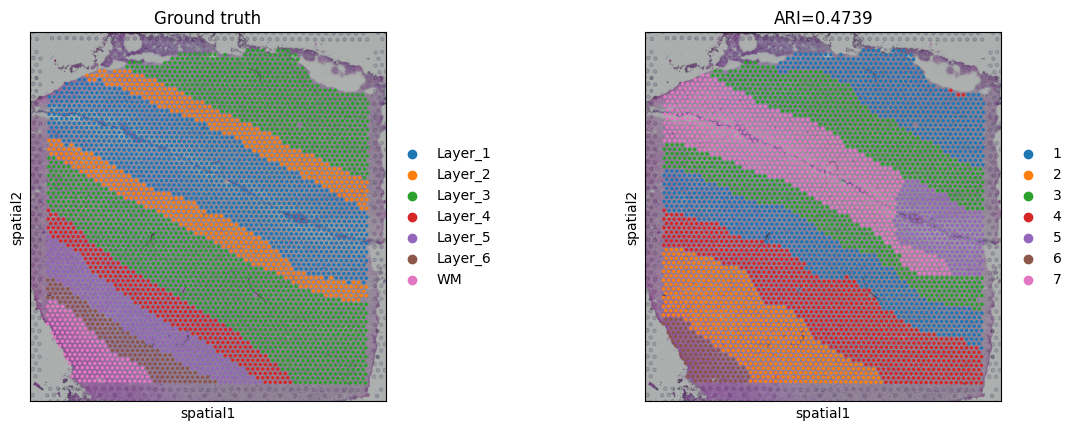

In [103]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["layer_guess", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

In [105]:
# # plotting predicted labels by UMAP
# sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)